> May 06, 2024 | {sub-ref}`wordcount-minutes` min read




(sec_El_Modelo_de_Ising_con_el_algoritmo_VQE)= 
# El Modelo de Ising con el algoritmo VQE

In [9]:
# Librerías generales
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product
import random
import scipy
import matplotlib.pyplot as plt

# Librerías Qibo
import qibo
from qibo import models, gates, hamiltonians
from qibo import matrices as m

# Librerías Qiskit
import qiskit
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit.library import TwoLocal
from qiskit.tools.parallel import parallel_map

random.seed()

qibo.set_backend("numpy")

%matplotlib inline

[Qibo 0.1.12.dev0|INFO|2024-04-18 11:12:17]: Using numpy backend on /CPU:0


:::{contents}
:local:
:depth: 1
:::


(sec_Introduccion_al_Modelo_de_Ising)= 
## Introducción al Modelo de Ising

El Modelo de Ising es un modelo para entender los materiales magnéticos en términos de los *spines* de los átomos y los electrones que lo forman. Pdemos imaginar el sólido magnético como una red cristalina, y en cada uno de los nodos tenemos una flecha que apunta hacia arriba ($\uparrow$) o hacia abajo ($\downarrow$). Si dos flechas contiguas apuntan en la misma dirección ($\uparrow \uparrow$ o $\downarrow \downarrow$), esta unión tiene una contribución negativa a la energía del sistema: el sistema tiende a alinear los *spines* entre si. Por otro lado si las flechas apuntan en direcciones contrarias ($\uparrow \downarrow$), la energía de esa unión es positiva: al sistema le "cuesta" mantener flechas en direcciones opuestas.


Existen dos factores externos que pueden condicionar el estado del sistema: el campo magnético y la temperatura a los que lo sometemos. Por un lado, si introducimos un campo magnético apuntando hacia arriba, los *spines* tienden a alinearse con el campo, por lo que todos querrán apuntar hacia arriba. Por otro lado, si calentamos mucho el sistema, las excitaciones térmicas provocarán que los *spines* se agiten, cambiando de dirección y desordenándose.


En el caso cuántico, las fluctuaciones cuánticas del sistema provocan cambios en estos spines incluso a temperatura cero, permitiendo la existencia de transiciones de fase cuánticas.

Podemos expresar el Hamiltoniano del sistema como:

$$
\mathcal{H} = - J \sum_{\langle i,j \rangle} \sigma_i \sigma_j - h \sum_i \sigma_i \;,
$$

donde $J$ es la contribución energética de la interacción de dos *spines* adyacentes (fijémonos en que en el primer sumatorio solo se suma a primeros vecinos, $\langle i,j \rangle$) y $h$ está relacionado con este campo magnético externo. $\sigma_i$ es la "etiqueta" del *spin* y vale $+1$ o $-1$ según apunte hacia arriba o hacia abajo.


Este problema puede complicarse dados diferentes factores microcópicos como la estructura cristalina o incluso tener interacciones más allá de los primeros vecinos, lo que requiere métodos aproximados para solucionarlo. No obstante, hay dos casos especiales para los que existe una solución exacta y analítica del modelo: cuando el sistema tiene solo una dimensión o cuando el sistema tiene dos dimensiones y una estructura cuadrada.

(sec_El_Modelo_de_Ising_1D)= 
### El Modelo de Ising 1D

Vamos a analizar el caso cuántico de la cadena de Ising **unidimensional**. Precisamente por la naturaleza cuántica del problema podemos utilizar las matrices de Pauli para caracterizar el Hamiltoniano, dando lugar a una nueva forma del operador {cite}`bib_cervera_lierta_exact_2018`: 

$$
\mathcal{H} = -J \sum_{i=1}^N X_i X_{i+1} - J g \sum_i Z_i \;,
$$

siendo $N$ la longitud de la cadena y, de nuevo, $J$ está relacionado con la energía del sistema y $g$ con la intensidad del campo magnético a primeros vecinos. $X_i$ y $Z_i$ son operadores de Pauli como los que introducíamos al principio de este documento, actuando sobre el *spin* en posición $i$.


Este modelo se conoce como **transverse field Ising Model**. A veces se define $\Gamma = J g$, donde $\Gamma$ se conoce como campo transverso.

::::::{admonition} Nota (Notación reducida) 
:class: note


    
En lo que a la descomposición de Pauli se refiere, los productos anteriores realmente son productos tensoriales de operadores para las partículas $i$ e $i+1$, teniendo identidades en el resto de posiciones. Por ejemplo, para una cadena de tres <i>spines</i>, $N=3$,  

$$
\mathcal{H} = -J(X \otimes X \otimes I + I \otimes X \otimes X + X \otimes I \otimes X) - J g (Z \otimes I \otimes I + I \otimes Z \otimes I + I \otimes I \otimes Z) \;,
$$    
donde hemos tomado condiciones de contorno periódicas ($\sigma_{N+1} \rightarrow \sigma_1$).

::::::


In [10]:
PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0,1],[1,0]], dtype=complex),
    "Y": np.array([[0,-1j],[1j,0]], dtype=complex),
    "Z": np.array([[1,0],[0,-1]], dtype=complex)
}

Vamos a redefinir nuestras constantes del problema $J$ y $g$ de forma que podamos expresarlas como magnitudes relativas, escribiendo nuestro operador como 

$$
\mathcal{H} = \sum_{i=1}^N X_i X_{i+1} + \gamma \sum_i Z_i \;.
$$

Ahora los signos ($-$) han pasado a ser positivos y solo tenemos una constante de acoplo, $\gamma$. Esto implica que, cuando $\gamma$ es positivo estamos en el caso ferromagnético y cuando es negativo en el antiferromagnético.


La función que implementa esto es la siguiente:

:::::{tab-set}
::::{tab-item} Qibo
```python

def ising_chain_ham_qibo(n, gam):
    
    # Esta función nos devuelve el Hamiltoniano en términos utilizables por los algoritmos de Qibo
    # n = number of spin positions
    # gam = transverse field parameter

    from qibo.symbols import X, Z

    sym_X = sum(X(i) * X(i+1) for i in range(n-1)) + (X(0) * X(n-1))
    sym_Z = sum(Z(i) for i in range(n))
    sym_H = sym_X + gam * sym_Z

    H = hamiltonians.SymbolicHamiltonian(sym_H)
    
    return H, H.matrix
```
::::
::::{tab-item} Qiskit
```python

def ising_chain_ham(n, gam):
    
    # Esta función nos devuelve el Hamiltoniano en términos utilizables por los algoritmos de Qiskit
    # n = number of spin positions
    # gam = transverse field parameter
    
    for i in range(n):
        vecX = [I] * n
        vecZ = [I] * n
        vecX[i] = X
        vecZ[i] = Z
        
        if i == n - 1:
            vecX[0] = X
        else:
            vecX[i+1] = X

        auxX = vecX[0]
        auxZ = vecZ[0]
        
        for a in vecX[1:n]:
            auxX = auxX ^ a
        for b in vecZ[1:n]:
            auxZ = auxZ ^ b
            
        if i == 0:
            H = (auxX) + (gam * auxZ)
        else:
            H = H + (auxX) + (gam * auxZ)

    return H


def ising_chain_matrix(n, gam):
    
    # Esta función devuelve el Hamiltoniano como un array (lista de listas)
      
    for i in range(n):
        HX = [PAULIS["I"]] * n
        HZ = [PAULIS["I"]] * n
        HX[i] = PAULIS["X"]
        HZ[i] = PAULIS["Z"]
        
        if i == n - 1:
            HX[0] = PAULIS["X"]
        else:
            HX[i+1] = PAULIS["X"]
            
        aux = reduce(np.kron, HZ)
        aux = [val * gam for val in aux]
        
        if i == 0:
            H = reduce(np.kron, HX) + aux
        else:            
            H = H + reduce(np.kron, HX) + aux
        
    return H
```
::::
:::::


In [11]:
'''Qibo_code_cell'''

def ising_chain_ham_qibo(n, gam):
    
    # Esta función nos devuelve el Hamiltoniano en términos utilizables por los algoritmos de Qibo
    # n = number of spin positions
    # gam = transverse field parameter

    from qibo.symbols import X, Z

    sym_X = sum(X(i) * X(i+1) for i in range(n-1)) + (X(0) * X(n-1))
    sym_Z = sum(Z(i) for i in range(n))
    sym_H = sym_X + gam * sym_Z

    H = hamiltonians.SymbolicHamiltonian(sym_H)
    
    return H, H.matrix

Vamos a resolver una cadena de Ising de $N = 4$ *spines*. Entonces prepararemos el Hamiltoniano y después le haremos una serie de transformaciones que nos permiten diagonalizarlo.


Empezamos por escribir nuestro operador. Como tenemos $N=4$ <i>spines</i>, el operador será 

$$
\mathcal{H} = X_1X_2I_3I_4 + I_1X_2X_3I_4 + I_1I_2X_3X_4 + X_1I_2I_3X_4 + \gamma (Z_1I_2I_3I_4 + I_1Z_2I_3I_4 + I_1I_2Z_3I_4 + I_1I_2I_3Z_4)
$$

Tomemos un valor de $\gamma$ pequeño, por ejemplo, $\gamma = 0.3$.

:::::{tab-set}
::::{tab-item} Qibo
```python

# Definimos el Hamiltoniano
n = 4
gam = .3

op_H, matrix = ising_chain_ham_qibo(n,gam)
```
::::
::::{tab-item} Qiskit
```python

# Definimos el Hamiltoniano
n = 4
gam = 0.3
op_H = ising_chain_ham(n,gam)
matrix = ising_chain_matrix(n, gam)
```
::::
:::::


In [13]:
'''Qibo_code_cell'''

# Definimos el Hamiltoniano
n = 4
gam = .3

op_H, matrix = ising_chain_ham_qibo(n,gam)

[Qibo 0.1.12.dev0|WARNING|2024-04-18 11:12:30]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


:::::{tab-set}
::::{tab-item} Qibo
```python

# Ahora creamos un circuito variacional de ansatz
# En este caso usamos un circuito de puertas RY(theta) y CZ, haciendo los diferentes valores de theta aleatorios

nqubits = n
nlayers  = 8

circuit = models.Circuit(nqubits)

for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
    
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
```
::::
::::{tab-item} Qiskit
```python

# Ahora creamos un circuito variacional de ansatz
# En este caso usamos un circuito de puertas RY(theta) y CZ, haciendo los diferentes valores de theta aleatorios

ansatz_circ = TwoLocal(num_qubits=n, rotation_blocks='ry', entanglement_blocks='cz')
```
::::
:::::


In [14]:
'''Qibo_code_cell'''

# Ahora creamos un circuito variacional de ansatz
# En este caso usamos un circuito de puertas RY(theta) y CZ, haciendo los diferentes valores de theta aleatorios

nqubits = n
nlayers  = 8

circuit = models.Circuit(nqubits)

for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
    
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))

En este caso, en lugar de utilizar el optimizador SPSA como hicimos en la sección anterior, empleamos uno nuevo: el método de Powell {cite}`bib_powell_efficient_1964`.

::::::{admonition} Nota (Eficiencia en la optimización) 
:class: note


    
El algoritmo de Powell que estamos empleando es considerablemente más eficiente que el resto de algoritmos que hemos probado para este problema específicamente. No obstante, su funcionamiento da lugar a unas gráficas de convergencia que no son particularmente ilustrativas. Si se quiere ver una gráfica en la que realmente se aprecie la convergencia del algoritmo, se puede probar a utilizar el algoritmo COBYLA. No obstante, la ejecución del código tardará un tiempo considerable (del orden de 20 minutos).

::::::


:::::{tab-set}
::::{tab-item} Qibo
```python

# Especificamos el algorimto de optimización clásica
# opt = 'COBYLA'
opt = 'Powell'
```
::::
::::{tab-item} Qiskit
```python

# Especificamos el algorimto de optimización clásica
# opt = COBYLA(maxiter = 10000)
opt = POWELL()
```
::::
:::::


In [15]:
'''Qibo_code_cell'''

# Especificamos el algorimto de optimización clásica
# opt = 'COBYLA'
opt = 'Powell'

Implementamos unas funciones de callback para poder almacenar los datos de cada iteración y hacer un análisis de la convergencia.

:::::{tab-set}
::::{tab-item} Qibo
```python

# Esto son funciones auxiliares para guardar los datos de las iteraciones

intermediate_info = {
    'parameters': [],
    'energy': [],
    #'stddev': []
}

def callback(p):
    intermediate_info['parameters'].append(p)    
    energy, _, _ = vqe.minimize(p, callback = None, method=opt, options = None, compile=False)
    intermediate_info['energy'].append(energy)
    #intermediate_info['stddev'].append(stddev)
```
::::
::::{tab-item} Qiskit
```python

# Esto son funciones auxiliares para guardar los datos de las iteraciones

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
```
::::
:::::


In [16]:
'''Qibo_code_cell'''

# Esto son funciones auxiliares para guardar los datos de las iteraciones

intermediate_info = {
    'parameters': [],
    'energy': [],
    #'stddev': []
}

def callback(p):
    intermediate_info['parameters'].append(p)    
    energy, _, _ = vqe.minimize(p, callback = None, method=opt, options = None, compile=False)
    intermediate_info['energy'].append(energy)
    #intermediate_info['stddev'].append(stddev)

Como anticipamos previamente, vamos a hacer uso de la función ```vqe``` que está ya implementada, ya que es considerablemente más eficiente que la que programamos en la sección anterior.

:::::{tab-set}
::::{tab-item} Qibo
```python

# Parámetros del Ansatz
initial_parameters = np.random.uniform(-2*np.pi, 2*np.pi, 2*nqubits*nlayers + nqubits)

# Construcción del método VQE
vqe = models.VQE(circuit, op_H)
options = {'disp': True, 'return_all': True}

# Y ejecutamos el algoritmo
best, params, extra = vqe.minimize(initial_parameters, callback = callback, method=opt, options = options, compile=False)

values = intermediate_info['energy']
```
::::
::::{tab-item} Qiskit
```python

# Simulador/Ordenador cuántico
backend = Aer.get_backend('statevector_simulator')

# Entorno para la resolución
algorithm_globals.random_seed = 63
qi = QuantumInstance(backend, seed_transpiler=63, seed_simulator=63)

# Algoritmo VQE, introduciendo el ansatz y el optimizador elegidos
vqe_proc = VQE(estimator = Estimator() ,ansatz=ansatz_circ, optimizer=opt, callback=store_intermediate_result)
vqe_proc.quantum_instance = qi

# Resultados
sol = vqe_proc.compute_minimum_eigenvalue(operator = op_H)
# print(sol, "\n")
best = sol.optimal_value
```
::::
:::::


In [17]:
'''Qibo_code_cell'''

# Parámetros del Ansatz
initial_parameters = np.random.uniform(-2*np.pi, 2*np.pi, 2*nqubits*nlayers + nqubits)

# Construcción del método VQE
vqe = models.VQE(circuit, op_H)
options = {'disp': True, 'return_all': True}

# Y ejecutamos el algoritmo
best, params, extra = vqe.minimize(initial_parameters, callback = callback, method=opt, options = options, compile=False)

values = intermediate_info['energy']

Optimization terminated successfully.
         Current function value: -4.091731
         Iterations: 3
         Function evaluations: 1863


In [18]:
# Y ya vemos el valor de la solución:
print("E_G =",best)

E_G = -4.091731415003743


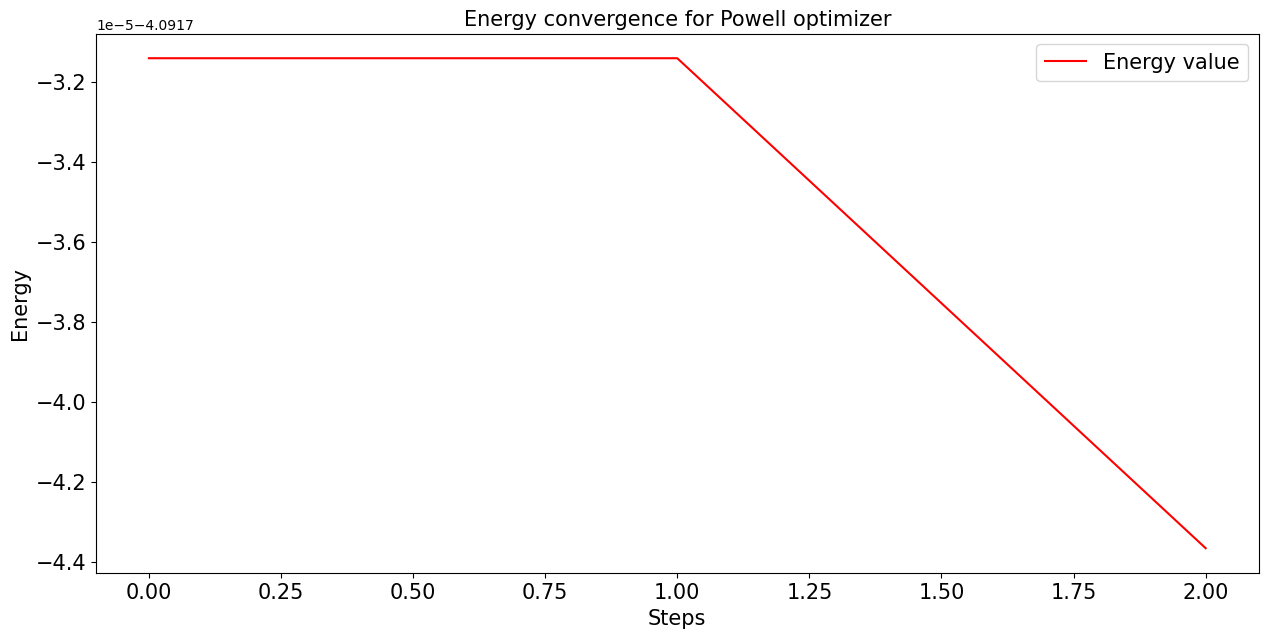

In [19]:
# Con la información de las iteraciones podemos dibujar la convergencia de nuestro código

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(values)), values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Powell optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

También comparamos con el valor que obtenemos simplemente de diagonalizar la matriz, ya que, al ser "pequeña" ($16 \times 16$), ```scipy``` no tiene problema en hacerlo.

In [20]:
eigvals, eigvecs = scipy.linalg.eig(matrix)

print("E_G =", min(eigvals).real)

print("Error relativo =", abs((best - min(eigvals).real)/min(eigvals).real) * 100, "%")

E_G = -4.092961599426855
Error relativo = 0.030056094913869277 %


---
Authors:

Irais Bautista ([CESGA](http://www.cesga.es)), Sergio Martínez ([BIFi-UNIZAR](https://bifi.es/es/)), Jaime Scharfhausen ([UAM](https://www.uam.es/uam/inicio)) y Alejandro Jaramillo ([CSUC](https://www.csuc.cat/es))

<img src="https://quantumspain-project.es/wp-content/uploads/2022/11/CESGA.png" width="150px">
<img src="http://bifi.es/wp-content/uploads/2016/11/logo_vectorial-web.png" width="200px">
<img src="https://www.iib.uam.es/iiblf6theme-theme/images/custom/logo-uam.png" width = "200px">
<img src="https://www.csuc.cat/sites/default/files/2021-02/CSUC_logo_corporatiu_0.png" width = "200px">


---
::::{figure} https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png
:width: 2000px
:align: center
::::

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>